In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import time
from matplotlib import pyplot as plt

# AlexNet的PyTorch复现（猫狗大战）

## 1. 数据集制作

在论文中AlexNet作者使用的是ILSVRC 2012比赛数据集，该数据集非常大（有138G），下载、训练都很消耗时间，我们在复现的时候就不用这个数据集了。由于MNIST、CIFAR10、CIFAR100这些数据集图片尺寸都较小，不符合AlexNet网络输入尺寸227x227的要求，因此我们改用kaggle比赛经典的“猫狗大战”数据集了。

该数据集包含的训练集总共25000张图片，猫狗各12500张，带标签；测试集总共12500张，不带标签。我们仅使用带标签的25000张图片，分别拿出2500张猫和狗的图片作为模型的验证集。我们按照以下目录层级结构，将数据集图片放好。

![](./images/path.png)

为了方便大家训练，我们将该数据集放在百度云盘，下载链接：
链接：https://pan.baidu.com/s/1UEOzxWWMLCUoLTxdWUkB4A 
提取码：cdue

### 1.1 制作图片数据的索引

准备好数据集之后，我们需要用PyTorch来读取并制作可以用来训练和测试的数据集。对于训练集和测试集，首先要分别制作对应的图片数据索引，即train.txt和test.txt两个文件，每个txt中包含每个图片的目录和对应类别class（cat对应的label=0，dog对应的label=1）。示意图如下：

![](./images/index.png)

制作图片数据索引train.txt和test.txt两个文件的python脚本程序如下：

In [2]:
import os

train_txt_path = os.path.join("data", "catVSdog", "train.txt")
train_dir = os.path.join("data", "catVSdog", "train_data")
valid_txt_path = os.path.join("data", "catVSdog", "test.txt")
valid_dir = os.path.join("data", "catVSdog", "test_data")

def gen_txt(txt_path, img_dir):
    f = open(txt_path, 'w')
    
    for root, s_dirs, _ in os.walk(img_dir, topdown=True):  # 获取 train文件下各文件夹名称
        for sub_dir in s_dirs:
            i_dir = os.path.join(root, sub_dir)             # 获取各类的文件夹 绝对路径
            img_list = os.listdir(i_dir)                    # 获取类别文件夹下所有png图片的路径
            for i in range(len(img_list)):
                if not img_list[i].endswith('jpg'):         # 若不是png文件，跳过
                    continue
                #label = (img_list[i].split('.')[0] == 'cat')? 0 : 1 
                label = img_list[i].split('.')[0]
                # 将字符类别转为整型类型表示
                if label == 'cat':
                    label = '0'
                else:
                    label = '1'
                img_path = os.path.join(i_dir, img_list[i])
                line = img_path + ' ' + label + '\n'
                f.write(line)
    f.close()

if __name__ == '__main__':
    gen_txt(train_txt_path, train_dir)
    gen_txt(valid_txt_path, valid_dir)

运行脚本之后就在./data/catVSdog/目录下生成train.txt和test.txt两个索引文件。

### 1.2 构建Dataset子类

PyTorch 加载自己的数据集，需要写一个继承自torch.utils.data中Dataset类，并修改其中的__init__方法、__getitem__方法、__len__方法。默认加载的都是图片，__init__的目的是得到一个包含数据和标签的list，每个元素能找到图片位置和其对应标签。然后用__getitem__方法得到每个元素的图像像素矩阵和标签，返回img和label。

In [3]:
from PIL import Image
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0], int(words[1]))) # 类别转为整型int
            self.imgs = imgs 
            self.transform = transform
            self.target_transform = target_transform
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB') 
        #img = Image.open(fn)
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
    def __len__(self):
        return len(self.imgs)

getitem是核心函数。self.imgs是一个list，self.imgs[index]是一个str，包含图片路径，图片标签，这些信息是从上面生成的txt文件中读取；利用Image.open对图片进行读取，注意这里的img是单通道还是三通道的；self.transform(img)对图片进行处理，这个transform里边可以实现减均值、除标准差、随机裁剪、旋转、翻转、放射变换等操作。

### 1.3 加载数据集和数据预处理

当Mydataset构建好，剩下的操作就交给DataLoder来加载数据集。在DataLoder中，会触发Mydataset中的getiterm函数读取一张图片的数据和标签，并拼接成一个batch返回，作为模型真正的输入。

In [4]:
pipline_train = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    #随机旋转图片
    transforms.RandomHorizontalFlip(),
    #将图片尺寸resize到227x227
    transforms.Resize((227,227)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到227x227
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])
train_data = MyDataset('./data/catVSdog/train.txt', transform=pipline_train)
test_data = MyDataset('./data/catVSdog/test.txt', transform=pipline_test)

#train_data 和test_data包含多有的训练与测试数据，调用DataLoader批量加载
trainloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)
# 类别信息也是需要我们给定的
classes = ('cat', 'dog') # 对应label=0，label=1

在数据预处理中，我们将图片尺寸调整到227x227，符合AlexNet网络的输入要求。这是使用的是ImageNet的均值和标准差。使用Imagenet的均值和标准差是一种常见的做法。它们是根据数百万张图像计算得出的。如果要在自己的数据集上从头开始训练，则可以计算新的均值和标准差。均值mean = [0.485, 0.456, 0.406]，方差std = [0.229, 0.224, 0.225]，然后使用transforms.Normalize进行归一化操作。

我们来看一下最终制作的数据集图片和它们对应的标签：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


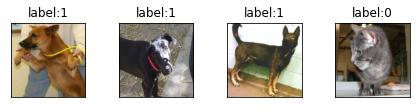

In [5]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_label) = next(examples)
# 批量展示图片
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.tight_layout()  #自动调整子图参数，使之填充整个图像区域
    img = example_data[i]
    img = img.numpy() # FloatTensor转为ndarray
    img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后
    #img = img * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(img)
    plt.title("label:{}".format(example_label[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## 2. 搭建AlexNet神经网络结构，并定义前向传播的过程

In [6]:
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        # input size should be : (b x 3 x 227 x 227)
        # The image in the original paper states that width and height are 224 pixels, but
        # the dimensions after first convolution layer do not lead to 55 x 55.
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=500),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=500, out_features=20),
            nn.ReLU(),
            nn.Linear(in_features=20, out_features=num_classes),
        )

    def forward(self, x):
        """
        Pass the input through the net.
        Args:
            x (Tensor): input tensor
        Returns:
            output (Tensor): output tensor
        """
        x = self.net(x)
        x = x.view(-1, 256 * 6 * 6)  # reduce the dimensions for linear layer input
        return self.classifier(x)

在构建AlexNet网络里，参数num_classes指的是类别的数量，由于论文中AlexNet的输出是1000个类别，我们这里的数据集只有猫和狗两个类别，因此这里的全连接层的神经元个数做了微调。num_classes=2，输出层也是两个神经元，不是原来的1000个神经元。FC6由原来的4096个神经元改为500个神经元，FC7由原来的4096个神经元改为20个神经元。这里的改动大家注意一下，根据实际数据集的类别数量进行调整。整个网络的其它结构跟论文中的完全一样。

## 3. 将定义好的网络结构搭载到GPU/CPU，并定义优化器

In [7]:
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet().to(device)
#定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. 定义训练过程

In [8]:
def train_runner(model, device, trainloader, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    total = 0
    correct =0.0
    
    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        outputs = model(inputs)
        #计算损失和
        #多分类情况通常使用cross_entropy(交叉熵损失函数), 而对于二分类问题, 通常使用sigmod
        loss = F.cross_entropy(outputs, labels)
        #获取最大概率的预测结果
        #dim=1表示返回每一行的最大值对应的列下标
        predict = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
        if i % 100 == 0:
            #loss.item()表示当前loss的数值
            print("Train Epoch{} \t Loss: {:.6f}, accuracy: {:.6f}%".format(epoch, loss.item(), 100*(correct/total)))
            Loss.append(loss.item())
            Accuracy.append(correct/total)
    return loss.item(), correct/total

## 5. 定义测试过程

In [9]:
def test_runner(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    test_loss = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, label).item()
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算损失值
        print("test_avarage_loss: {:.6f}, accuracy: {:.6f}%".format(test_loss/total, 100*(correct/total)))

## 6. 运行

start_time 2022-02-08 08:43:47
Train Epoch1 	 Loss: 0.706899, accuracy: 46.875000%
Train Epoch1 	 Loss: 0.691226, accuracy: 51.871906%
Train Epoch1 	 Loss: 0.633129, accuracy: 53.482587%
Train Epoch1 	 Loss: 0.627048, accuracy: 55.351952%
test_avarage_loss: 0.020481, accuracy: 61.800000%
end_time:  2022-02-08 09:12:29 

start_time 2022-02-08 09:12:29
Train Epoch2 	 Loss: 0.661039, accuracy: 65.625000%
Train Epoch2 	 Loss: 0.671636, accuracy: 63.010520%
Train Epoch2 	 Loss: 0.677994, accuracy: 63.401741%
Train Epoch2 	 Loss: 0.604137, accuracy: 63.797757%
test_avarage_loss: 0.020667, accuracy: 65.960000%
end_time:  2022-02-08 09:41:27 

start_time 2022-02-08 09:41:27
Train Epoch3 	 Loss: 0.760604, accuracy: 57.812500%
Train Epoch3 	 Loss: 0.630579, accuracy: 66.073639%
Train Epoch3 	 Loss: 0.562116, accuracy: 66.775498%
Train Epoch3 	 Loss: 0.604609, accuracy: 66.990241%
test_avarage_loss: 0.017850, accuracy: 71.220000%
end_time:  2022-02-08 10:10:15 

start_time 2022-02-08 10:10:15
Tra

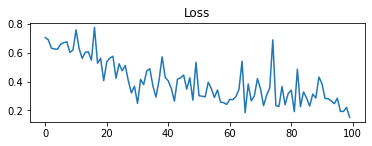

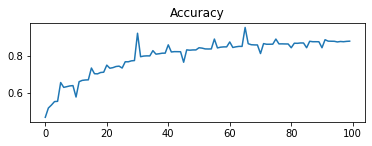

In [10]:
#调用
epoch = 20
Loss = []
Accuracy = []
for epoch in range(1, epoch+1):
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss, acc = train_runner(model, device, trainloader, optimizer, epoch)
    Loss.append(loss)
    Accuracy.append(acc)
    test_runner(model, device, testloader)
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('Finished Training')
plt.subplot(2,1,1)
plt.plot(Loss)
plt.title('Loss')
plt.show()
plt.subplot(2,1,2)
plt.plot(Accuracy)
plt.title('Accuracy')
plt.show()

## 7. 保存模型

In [11]:
print(model)
torch.save(model, './models/alexnet-catvsdog.pth') #保存模型

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=500, bias=True)
    (2): ReLU

C:\Users\Administrator\.conda\envs\pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## 8. 模型测试

下面使用一张猫狗大战测试集的图片进行模型的测试。

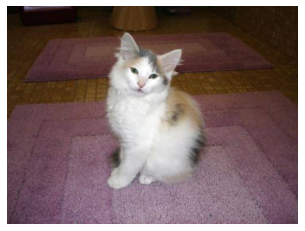

概率： tensor([[0.9983, 0.0017]], grad_fn=<SoftmaxBackward>)
预测类别： cat


In [12]:
from PIL import Image
import numpy as np

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/alexnet-catvsdog.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式
    
    #读取要预测的图片
    # 读取要预测的图片
    img = Image.open("./images/test_cat.jpg") # 读取图像
    #img.show()
    plt.imshow(img) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    
    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        ])
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    
    # 预测 
    # 预测 
    classes = ('cat', 'dog')
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是2个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    pred_class = classes[predicted.item()]
    print("预测类别：",pred_class)